# Telecom Churn Prediction - Machine Learning

In this notebook we will be executing the game plan that was made in the project EDA.
This project is to help predict churn for telecom. We will be testing 5 different clarification ML models. Decision Tree, Random Forest, XGBoost, LightGBM, and CatBoost.

## import liberaris

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

## load data

In [2]:
df_1 = pd.read_csv('/datasets/final_provider/contract.csv')
df_2 = pd.read_csv('/datasets/final_provider/personal.csv')
df_3 = pd.read_csv('/datasets/final_provider/internet.csv')
df_4 = pd.read_csv('/datasets/final_provider/phone.csv')

print("Contract Data:")
display(df_1.head())

print("Personal Data:")
display(df_2.head())

print("Internet Data:")
display(df_3.head())

print("Phone Data:")
display(df_4.head())

df_merged = pd.merge(df_1, df_2, on='customerID', how='inner')

df_merged = pd.merge(df_merged, df_3, on='customerID', how='inner')

df_merged = pd.merge(df_merged, df_4, on='customerID', how='inner')

display(df_merged.head())

Contract Data:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Personal Data:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Internet Data:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Phone Data:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
1,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
2,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
3,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes


## Clean data

In [3]:
df_merged['BeginDate'] = pd.to_datetime(df_merged['BeginDate'], errors='coerce')
df_merged['EndDate'] = pd.to_datetime(df_merged['EndDate'], errors='coerce')

df_merged['TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'], errors='coerce')
print(df_merged['TotalCharges'].isna().sum()) 
df_merged = df_merged.dropna(subset=['TotalCharges'])
df_merged = df_merged.reset_index(drop=True)
print(df_merged['TotalCharges'].isna().sum())
yes_no_columns = [
    'PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]
df_merged[yes_no_columns] = df_merged[yes_no_columns].replace({'Yes': 1, 'No': 0})

print(df_merged.info())

3
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4832 entries, 0 to 4831
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        4832 non-null   object        
 1   BeginDate         4832 non-null   datetime64[ns]
 2   EndDate           1586 non-null   datetime64[ns]
 3   Type              4832 non-null   object        
 4   PaperlessBilling  4832 non-null   int64         
 5   PaymentMethod     4832 non-null   object        
 6   MonthlyCharges    4832 non-null   float64       
 7   TotalCharges      4832 non-null   float64       
 8   gender            4832 non-null   object        
 9   SeniorCitizen     4832 non-null   int64         
 10  Partner           4832 non-null   int64         
 11  Dependents        4832 non-null   int64         
 12  InternetService   4832 non-null   object        
 13  OnlineSecurity    4832 non-null   int64         
 14  OnlineBackup      48

## feature engenearing

### Tenure

In [4]:
today = pd.to_datetime('today')

df_merged['EndDateFilled'] = df_merged['EndDate'].fillna(today)
df_merged['tenure_days'] = (df_merged['EndDateFilled'] - df_merged['BeginDate']).dt.days
df_merged['tenure_months'] = (df_merged['tenure_days'] / 30).round()

### Churn

In [5]:
df_merged['churn'] = df_merged['EndDate'].notna().astype(int)

### Contract type

In [6]:
contract = {
    'Month-to-month': 1,
    'One year': 12,
    'Two year': 24
}
df_merged['contract_length_months'] = df_merged['Type'].map(contract)

### Feature Encoding (OHE)

In [7]:
ohe_cols = ['Type', 'PaymentMethod', 'InternetService']

df_encoded = pd.get_dummies(df_merged, columns=ohe_cols, drop_first=False)

print(df_encoded.shape)
print(df_encoded.columns)


(4832, 31)
Index(['customerID', 'BeginDate', 'EndDate', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'EndDateFilled', 'tenure_days', 'tenure_months', 'churn',
       'contract_length_months', 'Type_Month-to-month', 'Type_One year',
       'Type_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic'],
      dtype='object')


## split data

### Drop irrelevant columns

In [8]:
df_encoded.drop(['customerID','gender','BeginDate','EndDate','EndDateFilled','tenure_days','tenure_months'], axis=1, inplace=True)
print(df_encoded.columns)


Index(['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
       'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'churn', 'contract_length_months',
       'Type_Month-to-month', 'Type_One year', 'Type_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic'],
      dtype='object')


In [9]:
df_encoded.duplicated().sum()
df_encoded = df_encoded.drop_duplicates()
df_encoded.duplicated().sum()

0

I had to drop tenure to stop data leaks

We no longer need start and end date because of the features we engeneared.

### split

In [10]:
features = df_encoded.drop(['churn'], axis=1)
target = df_encoded['churn']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=12345)

## Apply balancing

In [12]:
mask_majority = y_train == 0
mask_minority = y_train == 1

X_majority = X_train[mask_majority]
X_minority = X_train[mask_minority]

y_majority = y_train[mask_majority]
y_minority = y_train[mask_minority]

X_minority_upsampled = X_minority.sample(n=len(X_majority), replace=True, random_state=12345)
y_minority_upsampled = y_minority.sample(n=len(y_majority), replace=True, random_state=12345)

X_train_bal = pd.concat([X_majority, X_minority_upsampled])
y_train_bal = pd.concat([y_majority, y_minority_upsampled])

X_train_bal = X_train_bal.sample(frac=1, random_state=12345).reset_index(drop=True)
y_train_bal = y_train_bal.sample(frac=1, random_state=12345).reset_index(drop=True)


This method works but it could be worth wile looking into SMOTE.

## model training

In [13]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=12345),
    'Random Forest': RandomForestClassifier(random_state=12345),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='auc'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}


for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred))
    y_probs = model.predict_proba(X_test)[:, 1]
    print(f"ROC-AUC: {roc_auc_score(y_test, y_probs):.4f}")




Decision Tree Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77       649
           1       0.53      0.52      0.52       315

    accuracy                           0.69       964
   macro avg       0.65      0.65      0.65       964
weighted avg       0.69      0.69      0.69       964

ROC-AUC: 0.6478

Random Forest Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       649
           1       0.61      0.56      0.58       315

    accuracy                           0.74       964
   macro avg       0.70      0.69      0.70       964
weighted avg       0.73      0.74      0.74       964

ROC-AUC: 0.7697

XGBoost Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       649
           1       0.57      0.61      0.59       315

    accuracy                           0.72       964
   macro avg       0.69      0.70

our best model is our CATBoost model with as score of ROC-AUC: .7986. now we can cross validate and tune our hyper peramiters to make sure our model is working properly.

## feature importance

                           Feature  Importance
2                     TotalCharges   24.504817
1                   MonthlyCharges   17.660782
13          contract_length_months    5.447470
0                 PaperlessBilling    4.062620
7                     OnlineBackup    3.647622
19  PaymentMethod_Electronic check    3.330284
12                   MultipleLines    3.097516
11                 StreamingMovies    2.973441
6                   OnlineSecurity    2.969342
4                          Partner    2.794614


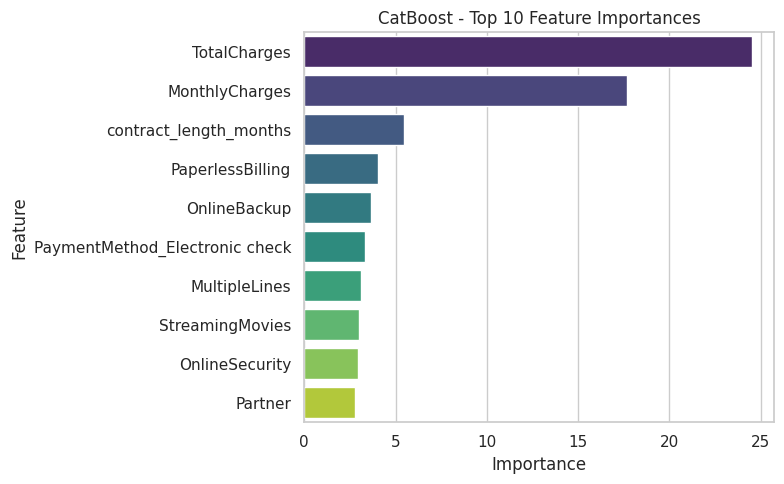

In [14]:
cat_model = models['CatBoost']
importances = cat_model.feature_importances_

feat_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importance_df.head(10))

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('CatBoost - Top 10 Feature Importances')
plt.tight_layout()
plt.show()


Total amount the customer has paid is the strongest predictor of churn.
Monthly bill is the second most important factor. High bills may correlate with churn.
Longer contracts might reduce churn. shorter contracts may increase it.


## Hyper peramiter tuning

In [15]:
param_dist = {
    'iterations': list(np.arange(100, 600, 50)),
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bootstrap_type': ['Bayesian'],
    'random_strength': [1, 3, 5, 7, 9], 
    'bagging_temperature': list(np.arange(0, 11, 2))
}

cat = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=0,
    random_state=12345,
    task_type='CPU'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

random_search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=12345
)

random_search.fit(X_train, y_train)

best_cat = random_search.best_estimator_
print("Best parameters:\n", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bagging_temperature=10, bootstrap_type=Bayesian, depth=4, iterations=550, l2_leaf_reg=7, learning_rate=0.01, random_strength=5; total time=   0.7s
[CV] END bagging_temperature=10, bootstrap_type=Bayesian, depth=4, iterations=550, l2_leaf_reg=7, learning_rate=0.01, random_strength=5; total time=   0.7s
[CV] END bagging_temperature=4, bootstrap_type=Bayesian, depth=10, iterations=450, l2_leaf_reg=5, learning_rate=0.05, random_strength=9; total time=   7.0s
[CV] END bagging_temperature=4, bootstrap_type=Bayesian, depth=10, iterations=450, l2_leaf_reg=5, learning_rate=0.05, random_strength=9; total time=   7.6s
[CV] END bagging_temperature=4, bootstrap_type=Bayesian, depth=10, iterations=450, l2_leaf_reg=5, learning_rate=0.05, random_strength=9; total time=   6.8s
[CV] END bagging_temperature=8, bootstrap_type=Bayesian, depth=10, iterations=500, l2_leaf_reg=7, learning_rate=0.2, random_strength=3; total time=   8.1s
[CV

## model evaluation

In [16]:


y_pred = best_cat.predict(X_test)
y_probs = best_cat.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_probs):.4f}")




              precision    recall  f1-score   support

           0       0.80      0.87      0.83       649
           1       0.66      0.55      0.60       315

    accuracy                           0.76       964
   macro avg       0.73      0.71      0.71       964
weighted avg       0.75      0.76      0.75       964

ROC-AUC Score: 0.8126


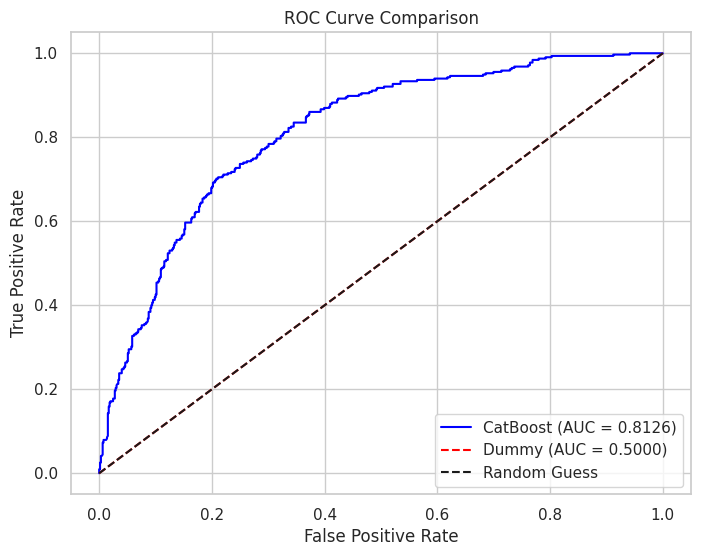

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, roc_auc_score


y_probs = best_cat.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
dummy.fit(X_train, y_train)
dummy_probs = dummy.predict_proba(X_test)[:, 1]
dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy_probs)
dummy_auc = roc_auc_score(y_test, dummy_probs)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"CatBoost (AUC = {roc_auc:.4f})", color='blue')
plt.plot(dummy_fpr, dummy_tpr, label=f"Dummy (AUC = {dummy_auc:.4f})", color='red', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


## Conclution


In this project, we developed a catboost classifier to predict customer churn for the telecom operator Interconnect. Using customer personal data, plan details, and contract information, our model achieved strong performance metrics:


              precision    recall  f1-score   support

           0       0.80      0.87      0.83       649
           1       0.66      0.55      0.60       315

    accuracy                           0.76       964
   macro avg       0.73      0.71      0.71       964
weighted avg       0.75      0.76      0.75       964

ROC-AUC Score: 0.8126

These results indicate that the model effectively identifies customers likely to churn, with balanced precision and recall across classes and no significant signs of overfitting.

With a high ROC-AUC of 81.26%, we can confidently support Interconnect’s marketing team in proactively targeting at risk customers with promotional offers and tailored plans to reduce churn.

## Recomendation

Customers with higher monthly bills are more likely to churn, while those on longer contracts tend to stay longer. In particular, customers on month-to-month plans exhibit a higher risk of leaving.

To reduce churn and improve customer retention, we recommend:

Focus retention efforts on high value customers with high total payments and monthly bills. Offering personalized incentives or discounts to these customers can improve loyalty.

Encourage customers to sign longer-term contracts by promoting benefits such as discounted rates or exclusive perks, which can reduce churn risk.

Design special offers targeted at month-to-month plan customers to encourage contract upgrades or longer commitments.

By implementing these targeted strategies, Interconnect can effectively lower churn rates and increase long-term customer value.

